In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [3]:
TRAIN_DATASET_PATH = './train.csv.zip'
TEST_DATASET_PATH = './test.csv'
TRAIN_PREPARED_DATASET_EXT_PATH = './train_ext.csv'

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, ",")
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945


In [5]:
train_df.shape

(10000, 20)

In [6]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Приведение типов

In [7]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Целевая переменная

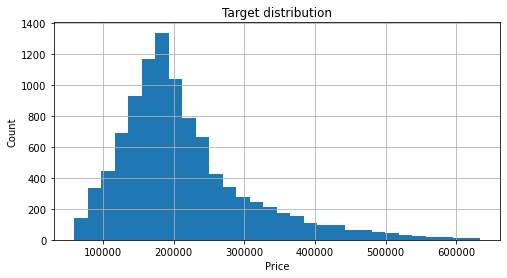

In [9]:
plt.figure(figsize = (8, 4))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

### Обраюотка выбросов и пропусков

HouseYear

In [10]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [11]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = datetime.now().year

HouseFloor

На основе года постройки привожу этажность дома к средней этажности домов за год

In [12]:
unique_numbers = list(set(train_df.loc[train_df['HouseFloor'] < train_df['Floor'],'HouseYear']))

In [13]:
for year in unique_numbers:
    year_median = train_df.loc[train_df['HouseYear'] == year, 'HouseFloor'].median()
    train_df.loc[train_df['HouseFloor'] < train_df['Floor'], 'HouseFloor'] = year_median
    train_df.loc[train_df['Floor'].isna(), 'HouseFloor'] = year_median   
for year in unique_numbers:
    year_median = train_df.loc[train_df['HouseYear'] == year, 'Floor'].median()
    train_df.loc[train_df['HouseFloor'] < train_df['Floor'], 'Floor'] = year_median

LifeSquare

На основе года постройки привожу жилую площадь к средней за год постройки

In [14]:
unique_numbers = list(set(train_df.loc[train_df['Square'] < train_df['LifeSquare'],'HouseYear']))

In [15]:
for year in unique_numbers:
    year_median = train_df.loc[train_df['HouseYear'] == year, 'LifeSquare'].median()
    train_df.loc[train_df['Square'] < train_df['LifeSquare'],'LifeSquare'] = year_median
    train_df.loc[train_df['LifeSquare'].isna(),'LifeSquare'] = year_median
for year in unique_numbers:
    year_median = train_df.loc[train_df['HouseYear'] == year, 'Square'].median()
    train_df.loc[train_df['Square'] < train_df['LifeSquare'],'Square'] = year_median

KitchenSquare

На основе года постройки привожу площадь кухни к средней за год постройки

In [16]:
unique_numbers = list(set(train_df.loc[train_df['Square'] < train_df['KitchenSquare'],'HouseYear']))

In [17]:
for year in unique_numbers:
    year_median = train_df.loc[train_df['HouseYear'] == year, 'KitchenSquare'].median()
    train_df.loc[train_df['Square'] < train_df['KitchenSquare'],'KitchenSquare'] = year_median
    train_df.loc[train_df['KitchenSquare'].isna(),'KitchenSquare'] = year_median
for year in unique_numbers:
    year_median = train_df.loc[train_df['HouseYear'] == year, 'Square'].median()
    train_df.loc[train_df['Square'] < train_df['KitchenSquare'],'Square'] = year_median

Rooms

In [18]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [19]:
train_df.loc[train_df['Rooms'] == 0,'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [20]:
train_df[train_df['Square'] < train_df['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [21]:
train_df[train_df['Square'] < train_df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [22]:
train_df[train_df['HouseFloor'] < train_df['Floor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Healthcare_1

In [23]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [24]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,56.391125,35.401208,5.859600,8.410000,13.649700,1984.872600,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.857399
std,0.811438,20.978221,15.205792,5.071357,5.059235,5.977103,18.416734,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.293865
min,1.000000,2.377248,0.370619,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.803396,25.634333,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.579623,37.160904,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,38.119757,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171
max,5.000000,641.065193,638.163193,123.000000,42.000000,117.000000,2021.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570


In [25]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        unique_numbers = None
        year_median = None
        year = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
                
        # KitchenSquare
        
        unique_numbers = list(set(X.loc[X['Square'] < X['KitchenSquare'],'HouseYear']))
        
        for year in unique_numbers:
            year_median = X.loc[X['HouseYear'] == year, 'KitchenSquare'].median()
            X.loc[X['Square'] < X['KitchenSquare'],'KitchenSquare'] = year_median
            X.loc[X['KitchenSquare'].isna(),'KitchenSquare'] = year_median
        for year in unique_numbers:
            year_median = X.loc[X['HouseYear'] == year, 'Square'].median()
            X.loc[X['Square'] < X['KitchenSquare'],'Square'] = year_median
        
        # HouseFloor, Floor
        
        unique_numbers = list(set(X.loc[X['HouseFloor'] < X['Floor'],'HouseYear']))
        
        for year in unique_numbers:
            year_median = X.loc[X['HouseYear'] == year, 'HouseFloor'].median()
            X.loc[X['HouseFloor'] < X['Floor'], 'HouseFloor'] = year_median
            X.loc[X['Floor'].isna(), 'HouseFloor'] = year_median   
        for year in unique_numbers:
            year_median = X.loc[X['HouseYear'] == year, 'Floor'].median()
            X.loc[X['HouseFloor'] < X['Floor'], 'Floor'] = year_median
        
        # HouseYear
        
        current_year = datetime.now().year
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        
        unique_numbers = list(set(X.loc[X['Square'] < X['LifeSquare'],'HouseYear']))
        
        for year in unique_numbers:
            year_median = X.loc[X['HouseYear'] == year, 'LifeSquare'].median()
            X.loc[X['Square'] < X['LifeSquare'],'LifeSquare'] = year_median
            X.loc[X['LifeSquare'].isna(),'LifeSquare'] = year_median
        for year in unique_numbers:
            year_median = X.loc[X['HouseYear'] == year, 'Square'].median()
            X.loc[X['Square'] < X['LifeSquare'],'Square'] = year_median
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков

Dummies

In [26]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

DistrictSize, IsDistrictLarge

In [27]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [28]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,11809,27,3.0,115.027311,38.119757,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,851
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,652
3,2352,1,1.0,40.409907,38.119757,1.0,10.0,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,89


In [29]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [30]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

Square

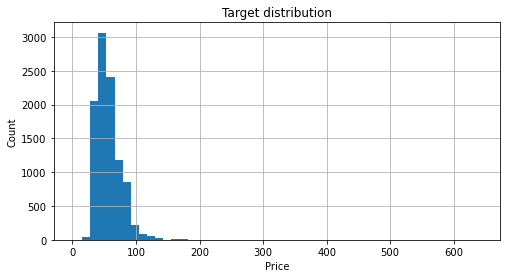

In [31]:
plt.figure(figsize = (8, 4))

train_df['Square'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

MedPriceByDistrict

In [32]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [33]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,38.119757,10.0,4.0,10.0,2014,0.075424,...,11,3097,0,0,0,1,305018.871089,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,30,6207,1,1,0,1,177734.553407,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,33,5261,0,3,1,1,282078.720850,652,1,244005.272380
3,2352,1,1.0,40.409907,38.119757,1.0,10.0,22.0,1977,0.007122,...,1,264,0,0,1,1,168106.007630,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,33,8667,2,0,6,1,343995.102962,89,0,201584.441255


MedPriceByFloorYear

In [34]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

def square_to_cat(X):

    X['square_cat'] = 0

    X.loc[X['Square'] <= 25, 'square_cat'] = 1
    X.loc[(X['Square'] > 25) & (X['Square'] <= 37), 'square_cat'] = 2
    X.loc[(X['Square'] > 37) & (X['Square'] <= 50), 'square_cat'] = 3
    X.loc[(X['Square'] > 50) & (X['Square'] <= 62), 'square_cat'] = 4
    X.loc[(X['Square'] > 62) & (X['Square'] <= 87), 'square_cat'] = 5
    X.loc[(X['Square'] > 87), 'square_cat'] = 6

    return X


def square_to_cat_pandas(X):
    bins = [0, 25, 37, 50, 62, 87, X['Square'].max()]
    X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
    X['square_cat'].fillna(-1, inplace=True)
    return X

In [35]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [36]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df = square_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,square_cat
0,11809,27,3.0,115.027311,38.119757,10.0,4.0,10.0,2014,0.075424,...,0,0,1,305018.871089,851,1,213530.788443,6,2,6
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,0,1,177734.553407,78,0,146032.829834,3,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,3,1,1,282078.720850,652,1,244005.272380,4,1,5
3,2352,1,1.0,40.409907,38.119757,1.0,10.0,22.0,1977,0.007122,...,0,1,1,168106.007630,652,1,146735.671740,3,4,3
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,6,1,343995.102962,89,0,201584.441255,3,5,5


In [37]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat', 'square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,square_cat,MedPriceByFloorYear
0,1,1,3,188973.569559
1,1,1,4,309988.239477
2,1,1,5,380359.112959
3,1,1,6,448706.902920
4,1,2,2,201311.771818


In [38]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat', 'square_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,square_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,38.119757,10.0,4.0,10.0,2014,0.075424,...,0,1,305018.871089,851,1,213530.788443,6,2,6,247653.663146
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,1,177734.553407,78,0,146032.829834,3,3,3,181125.084221
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1,1,282078.720850,652,1,244005.272380,4,1,5,299691.363838
3,2352,1,1.0,40.409907,38.119757,1.0,10.0,22.0,1977,0.007122,...,1,1,168106.007630,652,1,146735.671740,3,4,3,160571.015095
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,6,1,343995.102962,89,0,201584.441255,3,5,5,211284.693246


In [39]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size =None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            self.square_max = df['Square'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            df = self.square_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat', 'square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        x = self.square_to_cat(X) # + столбец square_cat
            # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat', 'square_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
    def square_to_cat(self, X):
        bins = [0, 25, 37, 50, 62, 87, self.square_max]
        X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
        X['square_cat'].fillna(-1, inplace=True)
        return X

### Отбор признаков

In [40]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'square_cat',
 'MedPriceByFloorYear']

In [41]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = [ 'DistrictSize','IsDistrictLarge', 'MedPriceByFloorYear','year_cat', 'square_cat', 'floor_cat']

target_name = 'Price'

### Разбиение на train и test

In [42]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=25)

In [44]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 18), (3000, 18), (5000, 18))

In [45]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 26), (3000, 26), (5000, 26))

In [46]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [47]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Построение модели

Обучение

In [48]:
rf_model = RandomForestRegressor(random_state=25, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=25)

Оценка модели

Train R2:	0.963
Test R2:	0.721


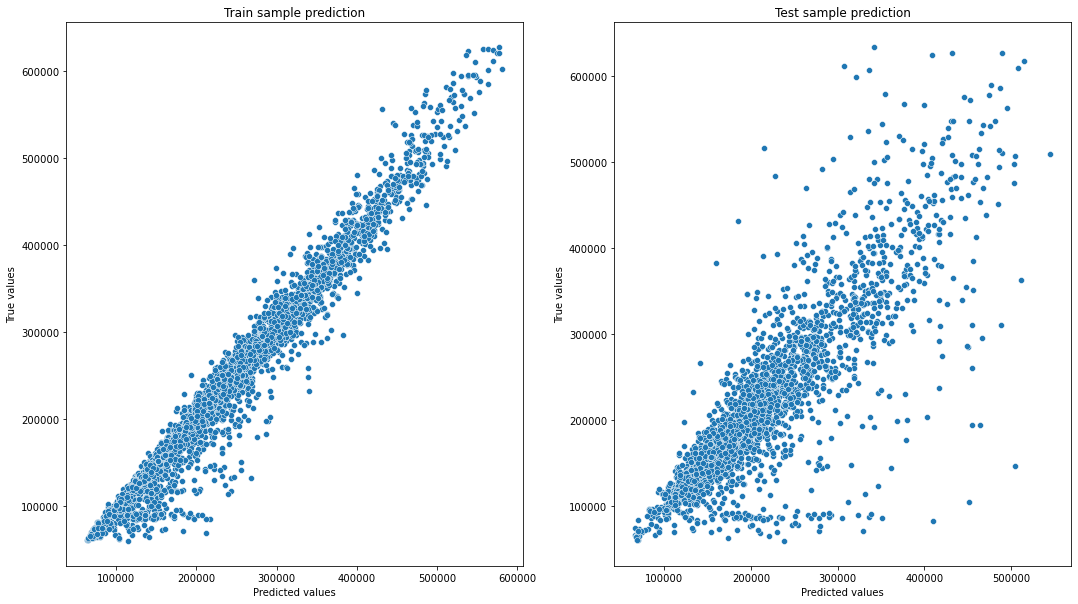

In [49]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [50]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=25))
cv_score

array([0.7408182 , 0.72573168, 0.70836164])

In [51]:
cv_score.mean()

0.7249705066026744

In [52]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.348010
16,DistrictSize,0.202816
18,MedPriceByFloorYear,0.149020
12,Social_3,0.049788
7,Ecology_1,0.033726
11,Social_2,0.027910
2,LifeSquare,0.027072
6,HouseYear,0.026668
10,Social_1,0.023719
5,HouseFloor,0.022269


In [53]:
test_df.shape

(5000, 22)

In [54]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3,Helthcare_2,Shops_1,Shops_2,DistrictSize,IsDistrictLarge,MedPriceByFloorYear,year_cat,square_cat,floor_cat
0,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,0.036122,1,1,...,0,1,1,1,70.0,0,156324.739511,2,1,1.0
1,1.0,42.493907,32.816228,10.0,7.0,17.0,2017,0.072158,1,1,...,1,0,0,0,166.0,1,131840.098904,5,2,2.0
2,2.0,59.463678,49.121078,9.0,19.0,19.0,1977,0.211401,1,1,...,0,0,1,1,591.0,1,178993.734724,2,3,4.0
3,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,1,1,...,0,0,0,1,404.0,1,174651.878037,2,2,0.0
4,1.0,53.837056,49.121078,1.0,8.0,17.0,1977,0.309479,1,1,...,4,0,6,1,86.0,0,204246.693475,2,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,6.0,6.0,1962,0.069660,1,1,...,4,1,2,1,69.0,0,181711.731436,2,2,2.0
4996,3.0,93.698122,49.121078,10.0,21.0,27.0,2018,0.060753,1,1,...,2,0,7,1,20.0,0,385670.449662,5,5,4.0
4997,1.0,33.656723,19.003259,5.0,2.0,5.0,1966,0.038693,1,1,...,1,2,5,1,74.0,0,152849.582453,2,1,0.0
4998,1.0,38.635155,20.976257,9.0,8.0,14.0,1970,0.089040,1,1,...,5,0,11,1,42.0,0,181711.731436,2,2,2.0


In [55]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [56]:
predictions = rf_model.predict(test_df)
predictions

array([152964.16931382, 119105.84555405, 143244.47561893, ...,
       148473.1129072 , 196635.41620325, 274527.02603246])

In [57]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,152964.169314
1,5925,119105.845554
2,960,143244.475619
3,3848,134504.091992
4,746,221350.180985


In [58]:
submit.to_csv('rf_submit.csv', index=False)